In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

from models.autoencoder import ConvAutoencoder

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")


DATA_PATH = r"data/flowers"
SAVE_PATH = "checkpoints/denoising_autoencoder.pth"
os.makedirs("checkpoints", exist_ok=True)
BATCH_SIZE = 64
IMG_SIZE = 128
EPOCHS = 40
LR = 1e-3
NOISE_FACTOR = 0.5 # Наскільки сильно псуємо картинку (0.0 - 1.0)

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(DATA_PATH, transform=transform)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

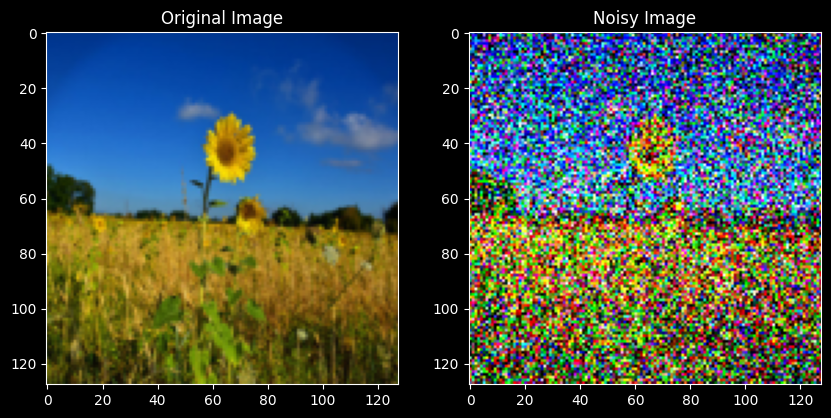

In [4]:
def add_noise(inputs, noise_factor):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    noisy = torch.clamp(noisy, 0., 1.)
    return noisy

sanple_imgs, _ = next(iter(train_loader))
noisy_imgs = add_noise(sanple_imgs, NOISE_FACTOR)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(np.transpose(sanple_imgs[0].numpy(), (1,
    2, 0)))
axes[0].set_title("Original Image")
axes[1].imshow(np.transpose(noisy_imgs[0].numpy(), (1,
    2, 0)))
axes[1].set_title("Noisy Image")
plt.show()


Starting training...
Epoch [1/40], Train Loss: 0.0797, Val Loss: 0.0590
Epoch [2/40], Train Loss: 0.0460, Val Loss: 0.0361
Epoch [3/40], Train Loss: 0.0308, Val Loss: 0.0287
Epoch [4/40], Train Loss: 0.0255, Val Loss: 0.0252
Epoch [5/40], Train Loss: 0.0236, Val Loss: 0.0234


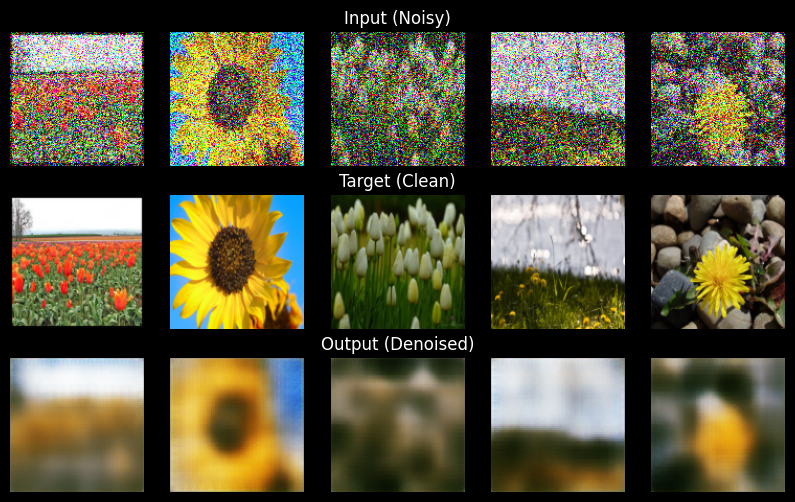

Epoch [6/40], Train Loss: 0.0220, Val Loss: 0.0226
Epoch [7/40], Train Loss: 0.0208, Val Loss: 0.0208
Epoch [8/40], Train Loss: 0.0196, Val Loss: 0.0204
Epoch [9/40], Train Loss: 0.0192, Val Loss: 0.0197
Epoch [10/40], Train Loss: 0.0184, Val Loss: 0.0190


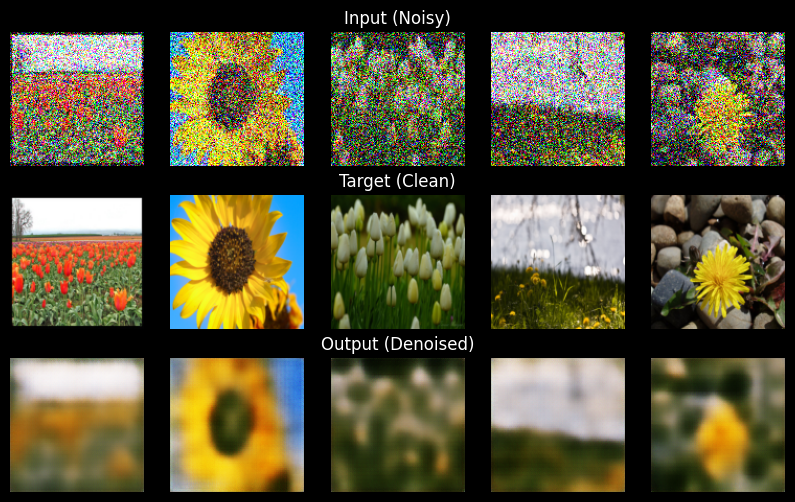

Epoch [11/40], Train Loss: 0.0175, Val Loss: 0.0179
Epoch [12/40], Train Loss: 0.0170, Val Loss: 0.0167
Epoch [13/40], Train Loss: 0.0156, Val Loss: 0.0162
Epoch [14/40], Train Loss: 0.0152, Val Loss: 0.0157
Epoch [15/40], Train Loss: 0.0145, Val Loss: 0.0149


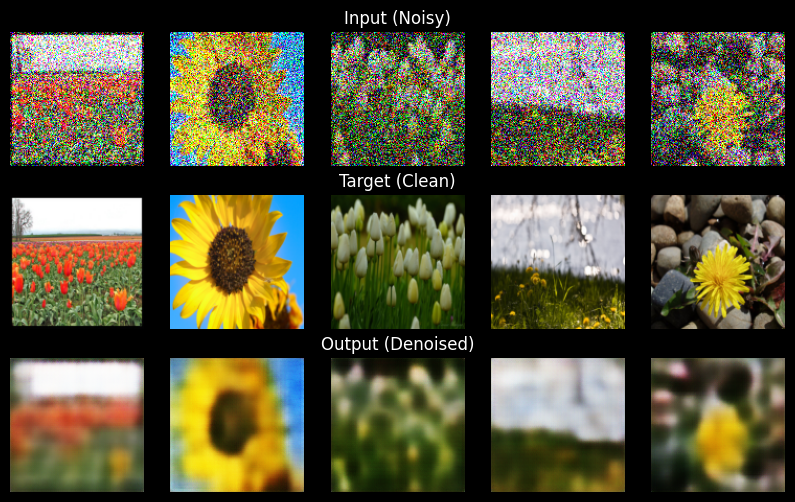

Epoch [16/40], Train Loss: 0.0142, Val Loss: 0.0145
Epoch [17/40], Train Loss: 0.0140, Val Loss: 0.0151
Epoch [18/40], Train Loss: 0.0141, Val Loss: 0.0141
Epoch [19/40], Train Loss: 0.0134, Val Loss: 0.0139
Epoch [20/40], Train Loss: 0.0135, Val Loss: 0.0138


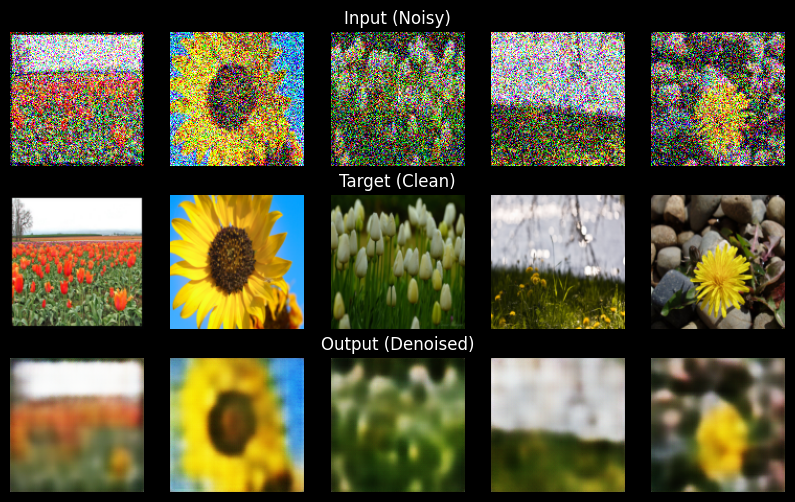

Epoch [21/40], Train Loss: 0.0130, Val Loss: 0.0139
Epoch [22/40], Train Loss: 0.0129, Val Loss: 0.0135
Epoch [23/40], Train Loss: 0.0128, Val Loss: 0.0132
Epoch [24/40], Train Loss: 0.0127, Val Loss: 0.0131
Epoch [25/40], Train Loss: 0.0125, Val Loss: 0.0129


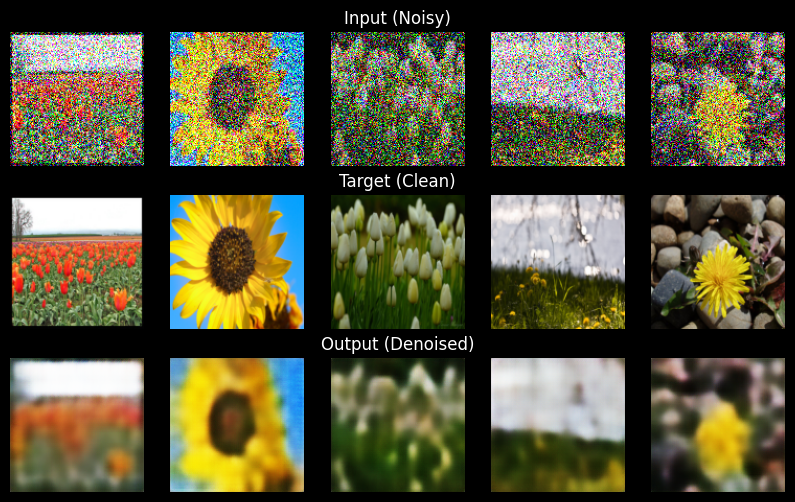

Epoch [26/40], Train Loss: 0.0123, Val Loss: 0.0129
Epoch [27/40], Train Loss: 0.0124, Val Loss: 0.0129
Epoch [28/40], Train Loss: 0.0120, Val Loss: 0.0127
Epoch [29/40], Train Loss: 0.0119, Val Loss: 0.0127
Epoch [30/40], Train Loss: 0.0119, Val Loss: 0.0126


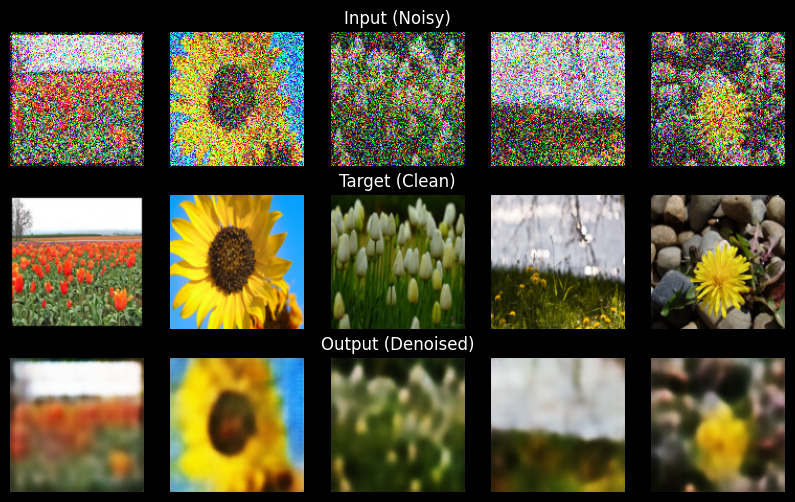

Epoch [31/40], Train Loss: 0.0118, Val Loss: 0.0122
Epoch [32/40], Train Loss: 0.0116, Val Loss: 0.0122
Epoch [33/40], Train Loss: 0.0117, Val Loss: 0.0123
Epoch [34/40], Train Loss: 0.0114, Val Loss: 0.0122
Epoch [35/40], Train Loss: 0.0116, Val Loss: 0.0120


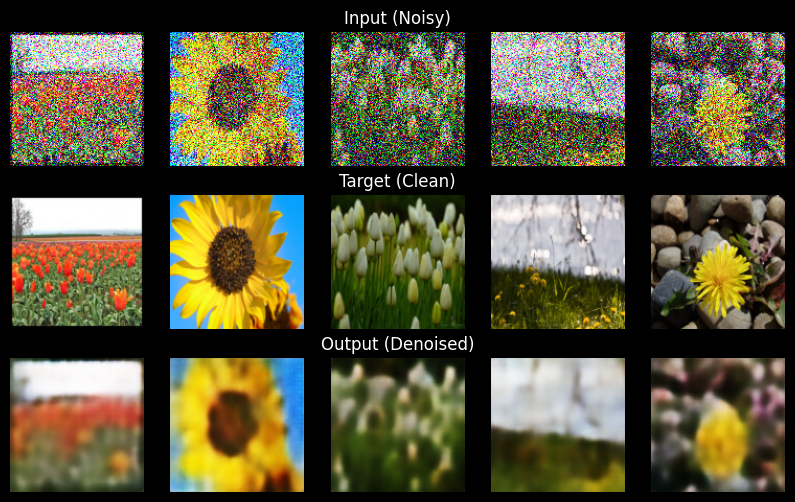

Epoch [36/40], Train Loss: 0.0112, Val Loss: 0.0117
Epoch [37/40], Train Loss: 0.0114, Val Loss: 0.0117
Epoch [38/40], Train Loss: 0.0111, Val Loss: 0.0118
Epoch [39/40], Train Loss: 0.0111, Val Loss: 0.0118
Epoch [40/40], Train Loss: 0.0109, Val Loss: 0.0116


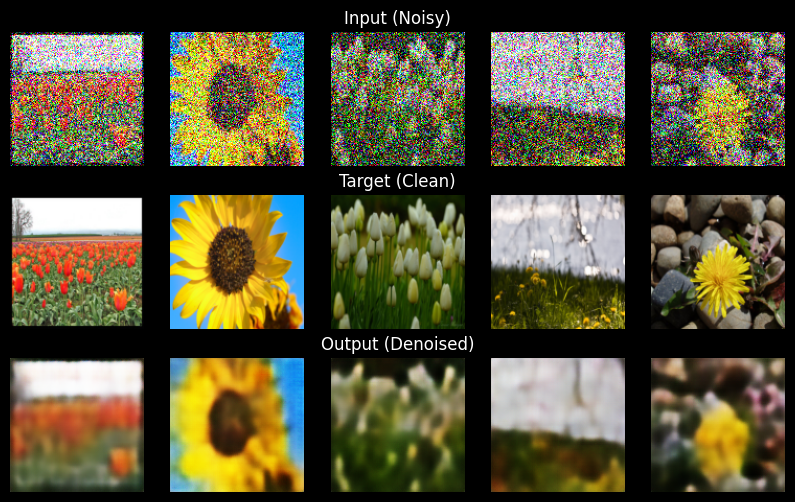

Denoising Model saved to checkpoints/denoising_autoencoder.pth


In [5]:
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
history = {'train_loss': [], 'val_loss': []}

print("Starting training...")
best_val_loss = float("inf")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        noisy_inputs = add_noise(inputs, NOISE_FACTOR).to(device)
        optimizer.zero_grad()
        outputs = model(noisy_inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            noisy_inputs = add_noise(inputs, NOISE_FACTOR).to(device)
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            sample, _ = next(iter(val_loader))
            sample = sample[:5].to(device)
            noisy = add_noise(sample, NOISE_FACTOR).to(device)
            recon = model(noisy)

            # Малюємо: Noisy -> Clean (Original) -> Reconstructed
            plt.figure(figsize=(10, 6))
            for i in range(5):
                plt.subplot(3, 5, i + 1)
                plt.imshow(noisy[i].cpu().permute(1, 2, 0))
                plt.axis('off')
                if i==2: plt.title("Input (Noisy)")

                plt.subplot(3, 5, i + 6)
                plt.imshow(sample[i].cpu().permute(1, 2, 0))
                plt.axis('off')
                if i==2: plt.title("Target (Clean)")

                plt.subplot(3, 5, i + 11)
                plt.imshow(recon[i].cpu().permute(1, 2, 0))
                plt.axis('off')
                if i==2: plt.title("Output (Denoised)")
            plt.show()

torch.save(model.state_dict(), SAVE_PATH)
print(f"Denoising Model saved to {SAVE_PATH}")


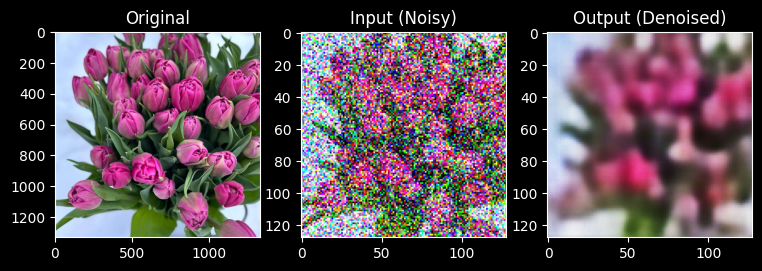

File: test.jpg | Loss: 0.02030
--------------------------------------------------


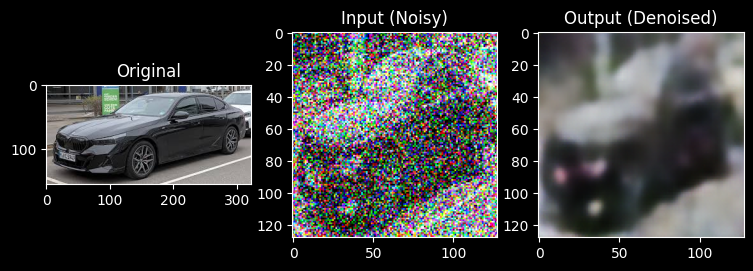

File: test_car.jpg | Loss: 0.00964
--------------------------------------------------


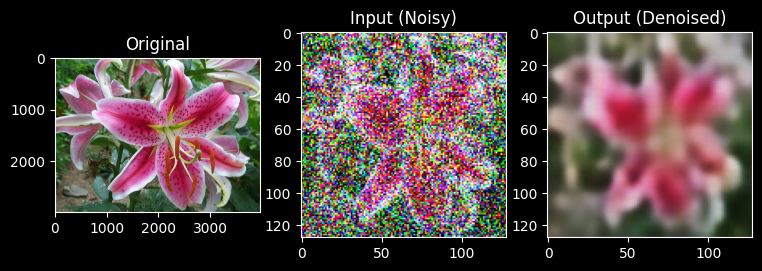

File: test_lily.jpg | Loss: 0.01696
--------------------------------------------------


In [6]:
model.eval()
losses = []
criterion = nn.MSELoss()

with torch.no_grad():
    for imgs, _ in val_loader:
        imgs = imgs.to(device)
        noisy_imgs = add_noise(imgs, NOISE_FACTOR)
        recon = model(noisy_imgs)

        for i in range(imgs.size(0)):
            loss = criterion(recon[i], imgs[i]).item()
            losses.append(loss)

def check_quick(img_path):
    if not os.path.exists(img_path): return

    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    noisy_tensor = add_noise(img_tensor, NOISE_FACTOR)
    with torch.no_grad():
        recon = model(noisy_tensor)
        loss = criterion(recon, img_tensor).item()

    plt.figure(figsize=(9, 3))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(noisy_tensor.squeeze(0).permute(1,2,0).cpu()); plt.title("Input (Noisy)")
    plt.subplot(1,3,3); plt.imshow(recon.squeeze(0).permute(1,2,0).cpu()); plt.title("Output (Denoised)")
    plt.show()

    print(f"File: {os.path.basename(img_path)} | Loss: {loss:.5f}")
    print("-" * 50)

check_quick("test.jpg")
check_quick("test_car.jpg")
check_quick("test_lily.jpg")